## Modeling Example: Buidling an Optimial Fantasy Football Team
Put together by Jerome Yurchisin ([@MathWithJerome]('https://twitter.com/MathWithJerome'))

### Predictive + Prescriptive Modeling
The goal of this notebook is to show how predictive analytics can be used in tandem with optimization modeling to get the best value out of machine learning projects. This example uses fantasy football as such a vehicle. 

### My Fantasy Football Model
In Fantasy Football the overall goal is to mix and match players from a set of games to great a lineup that scores the most *fantasy points* while the sum of each player's given salary is under a fixed number. 

There are several variations on lineup requirements, one is called *Captain Mode* in which you select only 6 players from a single game, you do not have any position requirements, and can select one player for the **Captain Slot**. This slot multiplies both the player's salary and overall fantasy score by 1.5x.

Some contests allow for submitting multiple lineups (up to 20 in many cases). Submitting multiple lineups can increase your chances in finishing very high in the contest, in which prize money is much higher. 

In [1]:
# Import python packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

It's assumed that player projection forecasts have been generated by a separate predictive model and that the output has been written to a csv file. This value is found in the *Points* column. 

In [2]:
projections = pd.read_csv("C:/Users/jerom/Desktop/Projects/daily_FF_R/projections_7.csv")
projections.head(10)

,Name,ID,Pos,Roster Position,Team,Points,Salary
0,Kyler Murray,24851258,QB,CPT,ARI,32.340,16800
1,Alvin Kamara,24851259,RB,CPT,NO,25.365,15900
2,DeAndre Hopkins,24851260,WR,CPT,ARI,21.450,15300
3,Andy Dalton,24851263,QB,CPT,NO,19.800,14100
4,Eno Benjamin,24851266,RB,CPT,ARI,22.320,12300
5,Chris Olave,24851267,WR,CPT,NO,21.030,11100
6,Taysom Hill,24851268,QB,CPT,NO,6.675,10800
7,Zach Ertz,24851269,TE,CPT,ARI,12.255,10500
8,Tre'Quan Smith,24851270,WR,CPT,NO,9.225,9300
9,Rondale Moore,24851273,WR,CPT,ARI,15.690,8700


To get a sense of how, even when only considering 46 players, that the number of possible lineups is huge. As mentioned above, there are no positional requirements for this mode of fantasy football, so to get the number of possible lineups we calculate the number of combinations of choosing 5 players from 46 (i.e. 46 choose 5) and then multiply that by the number of remaing player (46 - 5 = 41). 

In [3]:
n = len(projections)
print(f"The number of possible lineups: {int((n-5)*factorial(n)/(factorial(5)*factorial(n-5)))}")

The number of possible lineups: 31474716


### The Optimization Model
This model will be a linear [integer programming model]('https://en.wikipedia.org/wiki/Integer_programming'). Similar to other mathematical programming models (e.g. linear and mixed-integer) the key components are:
- Decision variables (the unknowns going into the model)
- Constraints (requirements of the problem, for example, only one *Captain* slot can be filled)
- Objective (what is to be maximized or minimized, in this case is maximize total points)

Read in the data for the players along with their projections and set the value for the salary cap, reindexing on the player/roster position combination. 

In [4]:
name_slot = projections['Name'] + projections['Roster Position']
names = projections['Name'].unique().tolist()
projections = projections.set_index(name_slot)
cap = 50000

#### Decision Variables
There are $i$ named players and since each player can occupy two potential slots there are $n = 2i$ player-slots.

Define $player_{k} = 1$ if the $k^{th}$ indexed player/roster position is selected and $0$ otherwise, for $k = 1, \dots ,n$. In this example, $n = 46$. 

In [5]:
# this starts the model so we can add compontents to it
model = gp.Model('multi_captain') 
# add the variable player to the model
player = model.addVars(name_slot, vtype = GRB.BINARY, name = "player")

#### Required Constraints  
The lineup must repsect the salary cap constraint  
$$\sum_{k=1}^{n} salary_k *player_{k,l} \le cap$$

In [6]:
model.addConstr((gp.quicksum(projections['Salary'][i]*player[i] for i in name_slot) <= cap), name = "caps");

A player can't be used as both a *Flex* and *Captain*.
$$player^{CAPT}_{k} + player^{FLEX}_{k} \le 1, \space\space k = 1,\dots,i$$

In [7]:
for name in names:
    model.addConstr(player[name+'CPT'] + player[name+'FLEX'] <= 1, name = name+'lim')

The lineup must have exactly one *Captian* roster position and exactly five *Flex* roster positions filled. 
$$\sum_{k \in CAPT}player_{k} = 1$$

$$\sum_{k \in FLEX}player_{k} = 5$$

In [8]:
model.addConstr((gp.quicksum(player[i] for i in name_slot if projections['Roster Position'][i]=="CPT") == 1), name = "cpt_lim")
model.addConstr((gp.quicksum(player[i] for i in name_slot if projections['Roster Position'][i]=="FLEX") == 5), name = "flex_lim");

#### Optional Constraints
The above contraints are required by the rules of the competition. But it is reasonable to assume some other contraints by on the preferance. For example, it's possible to limit the number of running backs (RB) selected to three, or limit the number of players from one specific team to five. Below are some of these optional requirements. Note that they may be reduntant given this particular example. For example, there are only two quarterbacks (QB) in the data and the constraints above will make sure they can't be selected twice, so a constraint that limits the total to two is not necessary in this case.

$$\sum_{k \in QB}player_{k,l} \le 2$$

$$\sum_{k \in Team_i}player_{k,l} \le 5, \space \space i = 1,2$$

In [9]:
model.addConstr((gp.quicksum(player[i] for i in name_slot if projections['Pos'][i]=="QB") <= 2), name = "qb_lim")
model.addConstr((gp.quicksum(player[i] for i in name_slot if projections['Pos'][i]=="RB") <= 3), name = "rb_lim")
model.addConstr((gp.quicksum(player[i] for i in name_slot if projections['Pos'][i]=="WR") <= 3), name = "wr_lim")
model.addConstr((gp.quicksum(player[i] for i in name_slot if projections['Pos'][i]=="DST") <= 1), name = "dst_lim")
model.addConstr((gp.quicksum(player[i] for i in name_slot if projections['Pos'][i]=="K") <= 2), name = "k_lim")
model.addConstr((gp.quicksum(player[i] for i in name_slot if projections['Team'][i]=="BUF") <= 5), name = "t1_lim")
model.addConstr((gp.quicksum(player[i] for i in name_slot if projections['Team'][i]=="NE") <= 5), name = "t2_lim");

#### Objective Function
As stated above, the goal is to maximize the total points for out lineups. 

$$Max\space Z = \sum_{k=1}^{n}points_k *player_{k}$$

In [10]:
model.setObjective(gp.quicksum(projections['Points'][i]*player[i] for i in name_slot), GRB.MAXIMIZE) 

It's possible to be interested in more solutions than just the single optimal lineup. For instance, there may be some late-breaking info that the predictive model isn't taking into consideration. The top $n$ solutions can be extracted by setting a couple of parameters to determine the number of solutions and if they need to be the top solutions. THen, run the optimization.

In [11]:
#Limit how many solutions to collect
nlineups = 512
model.setParam(GRB.Param.PoolSolutions, nlineups)
# Limit the search space by setting a gap for the worst possible solution that will be accepted
# Do a systematic search for the n-best solutions
model.setParam(GRB.Param.PoolSearchMode, 2)

Set parameter PoolSolutions to value 512
Set parameter PoolSearchMode to value 2


Run the optimization to find the top solutions. 

In [12]:
model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 31 rows, 42 columns and 164 nonzeros
Model fingerprint: 0x9f01c0df
Variable types: 0 continuous, 42 integer (42 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective 67.1100000
Presolve removed 5 rows and 0 columns
Presolve time: 0.00s
Presolved: 26 rows, 42 columns, 156 nonzeros
Variable types: 0 continuous, 42 integer (42 binary)
Found heuristic solution: objective 88.7700000

Root relaxation: objective 9.383653e+01, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   93.83653    0    2   88.77000   93.83653  5.71%     -    0s
H

The log above shows the objective value of the optimal aolution is 88.23 points. Next, loop through each solution and append the data from the projection dataframe that corresponds to the players selected in that solution.

In [13]:
import warnings
warnings.filterwarnings('ignore')

player_selections = pd.DataFrame()

for i in range(nlineups):
    model.setParam(GRB.Param.SolutionNumber, i)
    x = pd.Series(model.Xn, name = 'value')
    x = x[x > 0.9].index.tolist()
    tmp = projections.iloc[x]
    tmp['Lineup'] = i
    player_selections = player_selections.append(tmp)
    
player_selections.head(12)

,Name,ID,Pos,Roster Position,Team,Points,Salary,Lineup
Kyler MurrayCPT,Kyler Murray,24851258,QB,CPT,ARI,32.34,16800,0
Alvin KamaraFLEX,Alvin Kamara,24851317,RB,FLEX,NO,16.91,10600,0
Eno BenjaminFLEX,Eno Benjamin,24851324,RB,FLEX,ARI,14.88,8200,0
Chris OlaveFLEX,Chris Olave,24851325,WR,FLEX,NO,14.02,7400,0
Rondale MooreFLEX,Rondale Moore,24851331,WR,FLEX,ARI,10.46,5800,0
Keaontay IngramFLEX,Keaontay Ingram,24851349,RB,FLEX,ARI,4.42,400,0
Kyler MurrayCPT,Kyler Murray,24851258,QB,CPT,ARI,32.34,16800,1
Alvin KamaraFLEX,Alvin Kamara,24851317,RB,FLEX,NO,16.91,10600,1
Eno BenjaminFLEX,Eno Benjamin,24851324,RB,FLEX,ARI,14.88,8200,1
Chris OlaveFLEX,Chris Olave,24851325,WR,FLEX,NO,14.02,7400,1


The above shows the top two lineups. One may be interested in seeing how the total points and total salary changes by solution. Obvioulsly, the total points will decrease in a monotone fashion, but the salary is free to jump around. 

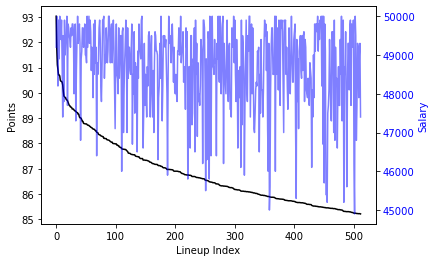

In [14]:
ps_group = player_selections.groupby('Lineup').agg({'Points':'sum','Salary':'sum'})

fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Lineup Index') 
ax1.set_ylabel('Points', color = 'black') 
plot_1 = ax1.plot(ps_group.index, ps_group.Points, color = 'black') 
ax1.tick_params(axis ='y', labelcolor = 'black') 

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Salary', color = 'blue') 
plot_2 = ax2.plot(ps_group.index, ps_group.Salary, color = 'blue', alpha = .5) 
ax2.tick_params(axis ='y', labelcolor = 'blue') 

Lastly, it can be checked to see in how many lineups each player appears. 

In [15]:
ps_cross = pd.crosstab(player_selections['Name'],player_selections['Roster Position'])
ps_cross['Total'] = ps_cross.CPT + ps_cross.FLEX
ps_cross.sort_values('Total', ascending=False)

Roster Position,CPT,FLEX,Total
Name,,,
Kyler Murray,232,279,511
Eno Benjamin,71,305,376
Chris Olave,72,297,369
Alvin Kamara,58,296,354
Rondale Moore,19,180,199
Wil Lutz,11,152,163
Keaontay Ingram,3,149,152
Andy Dalton,9,138,147
DeAndre Hopkins,9,126,135
